In [1]:
# Initial Setup - Clear previous results
from helper import clear_folder

clear_folder("ray_results")
clear_folder("outputs")
clear_folder("results")

print("Previous results cleared successfully!")

Previous results cleared successfully!


# Classic SVM with Optuna Hyperparameter Optimization

This notebook implements SVM hyperparameter optimization using Optuna instead of cross-validation approaches. The optimization focuses on finding the best parameters through efficient sampling and pruning strategies.

In [2]:
# Imports and Configuration
import os
import json
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any, Tuple
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
from sklearn.model_selection import train_test_split, StratifiedKFold
import optuna
from optuna.pruners import MedianPruner, PatientPruner
from optuna.samplers import TPESampler
import warnings
from collections import Counter
from statistics import mean, stdev
import logging

# Configure warnings and logging
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
logging.basicConfig(level=logging.INFO, format='%(message)s')

# Configuration
RANDOM_STATE = 42
RESULTS_DIR = "results"
BASE_DATA_PATH = os.path.join("data", "normalized")
DATASETS = ["A2", "A3", "A4", "A12", "A21"]

# Trial configuration (reduced for efficiency)
TRIAL_CONFIG = {
    "A2": {"n_trials": 150, "timeout_min": 8, "per_trial_time": 45},    # 2 classes
    "A3": {"n_trials": 150, "timeout_min": 8, "per_trial_time": 45},    # 2 classes  
    "A4": {"n_trials": 200, "timeout_min": 10, "per_trial_time": 60},  # 3 classes
    "A12": {"n_trials": 250, "timeout_min": 15, "per_trial_time": 90}, # 6 classes (challenging)
    "A21": {"n_trials": 150, "timeout_min": 8, "per_trial_time": 45}    # 2 classes
}

os.makedirs(RESULTS_DIR, exist_ok=True)
print("Configuration loaded successfully!")
print(f"Datasets to process: {DATASETS}")
print(f"Results will be saved to: {RESULTS_DIR}")

Configuration loaded successfully!
Datasets to process: ['A2', 'A3', 'A4', 'A12', 'A21']
Results will be saved to: results


In [3]:
# Utility Functions
def load_dataset(name: str) -> Tuple[pd.DataFrame, pd.Series]:
    """Load dataset and return features and target."""
    path = os.path.join(BASE_DATA_PATH, f"{name.lower()}.csv")
    df = pd.read_csv(path)
    X = df.drop(columns=["track"])
    y = df["track"]
    print(f"Loaded {name}: {X.shape[0]} samples, {X.shape[1]} features, {len(y.unique())} classes")
    return X, y

def make_holdout_split(X: pd.DataFrame, y: pd.Series, test_size: float = 0.2) -> Tuple[np.ndarray, ...]:
    """Create stratified train/validation split."""
    return train_test_split(
        X.values, y.values, test_size=test_size, stratify=y, random_state=RANDOM_STATE
    ) # type: ignore

def evaluate_metrics(y_true, y_pred) -> Dict[str, float]:
    """Calculate comprehensive evaluation metrics."""
    return {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "micro_f1": float(f1_score(y_true, y_pred, average="micro")),
        "macro_f1": float(f1_score(y_true, y_pred, average="macro")),
        "mcc": float(matthews_corrcoef(y_true, y_pred)),
    }

def save_json(obj: Any, path: str):
    """Save object as JSON with directory creation."""
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def get_pruner():
    """Get configured pruner for Optuna."""
    return PatientPruner(
        MedianPruner(n_warmup_steps=5), patience=8, min_delta=1e-4
    )

def get_sampler():
    """Get configured sampler for Optuna."""
    return TPESampler(seed=RANDOM_STATE, multivariate=True, group=True)

print("Utility functions defined successfully!")

Utility functions defined successfully!


In [4]:
# SVM Configuration and Parameter Suggestions
def suggest_svm_params(trial: optuna.Trial, dataset_name: str) -> Dict[str, Any]:
    """Suggest SVM hyperparameters with dataset-specific adaptations."""
    kernel = trial.suggest_categorical("kernel", ["rbf", "linear", "poly", "sigmoid"])
    
    # C parameter - log scale for wide range
    C = trial.suggest_float("C", 1e-3, 1e3, log=True)
    
    # Gamma parameter - with constraints to prevent hanging
    if kernel in ["rbf", "poly", "sigmoid"]:
        gamma_choice = trial.suggest_categorical("gamma_choice", ["auto", "scale", "float"])
        if gamma_choice == "float":
            # Constrain gamma range to prevent extreme values that cause hanging
            gamma = trial.suggest_float("gamma", 1e-4, 10.0, log=True)
        else:
            gamma = gamma_choice
    else:
        # Linear kernel doesn't use gamma
        gamma = "scale"
    
    # Kernel-specific parameters
    degree = trial.suggest_int("degree", 2, 5) if kernel == "poly" else 3
    coef0 = trial.suggest_float("coef0", -1.0, 1.0) if kernel in ["poly", "sigmoid"] else 0.0
    
    # Additional parameters with constraints
    shrinking = trial.suggest_categorical("shrinking", [True, False])
    tol = trial.suggest_float("tol", 1e-4, 1e-2, log=True)
    
    # Max iterations to prevent infinite training
    max_iter = trial.suggest_categorical("max_iter", [1000, 2000, 5000, 10000])
    
    # Special handling for challenging A12 dataset
    if dataset_name == "A12":
        # Consider class balancing for multiclass problem
        class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    else:
        class_weight = None
    
    return {
        "kernel": kernel, "C": C, "gamma": gamma, "degree": degree, 
        "coef0": coef0, "shrinking": shrinking, "tol": tol, 
        "class_weight": class_weight, "max_iter": max_iter
    }

def build_pipeline(params: Dict[str, Any]) -> Pipeline:
    """Build SVM pipeline with proper scaling for numerical stability."""
    svc = SVC(
        random_state=RANDOM_STATE,
        cache_size=400,
        **params
    )
    # Add StandardScaler back for numerical stability
    # Even though data is normalized, additional scaling helps with SVM convergence
    return Pipeline([
        ("scaler", StandardScaler()),
        ("clf", svc)
    ])

print("SVM configuration functions defined!")

SVM configuration functions defined!


In [5]:
# Optuna Objective Function
def create_objective(X_train, X_valid, y_train, y_valid, dataset_name: str, 
                    metric_name: str = "accuracy", per_trial_time_limit: int = 60):
    """Create objective function for Optuna optimization."""
    
    def objective(trial: optuna.Trial) -> float:
        params = suggest_svm_params(trial, dataset_name)
        pipeline = build_pipeline(params)
        
        # Progressive training schedule for efficient pruning
        schedule = [0.2, 0.5, 0.8, 1.0]
        n = len(X_train)
        
        trial.set_user_attr("params", params)
        trial.set_user_attr("dataset", dataset_name)
        
        start_time = time.time()
        score = None
        
        for step_idx, frac in enumerate(schedule, start=1):
            # Wall-clock time guard - be more aggressive with timeouts
            elapsed = time.time() - start_time
            if elapsed > per_trial_time_limit:
                print(f"Trial {trial.number}: Timeout at step {step_idx} ({elapsed:.1f}s)")
                raise optuna.TrialPruned()
            
            # Select subset of training data
            sub_n = max(20, int(math.ceil(n * frac)))
            if sub_n >= n:
                indices = np.arange(n)
            else:
                # Random stratified subset
                indices = train_test_split(
                    np.arange(n), test_size=1-frac, stratify=y_train, 
                    random_state=RANDOM_STATE + step_idx
                )[0]
            
            X_sub, y_sub = X_train[indices], y_train[indices]
            
            try:
                # Time the fitting process with individual timeout
                fit_start = time.time()
                
                # Fit with timeout monitoring
                pipeline.fit(X_sub, y_sub)
                fit_time = time.time() - fit_start
                
                # If fitting took too long, penalize this configuration
                max_fit_time = per_trial_time_limit / len(schedule)
                if fit_time > max_fit_time:
                    print(f"Trial {trial.number}: Slow fit at step {step_idx} ({fit_time:.1f}s)")
                    trial.set_user_attr("slow_convergence", True)
                    return 0.05  # Low penalty score
                
                # Predict and evaluate
                y_pred = pipeline.predict(X_valid)
                metrics = evaluate_metrics(y_valid, y_pred)
                score = metrics.get(metric_name, metrics["accuracy"])
                
                # Report for pruning
                trial.report(score, step_idx)
                trial.set_user_attr(f"fit_time_step_{step_idx}", fit_time)
                trial.set_user_attr(f"score_step_{step_idx}", score)
                
                # Check if should prune
                if trial.should_prune():
                    print(f"Trial {trial.number}: Pruned at step {step_idx} (score={score:.3f})")
                    raise optuna.TrialPruned()
                    
            except optuna.TrialPruned:
                raise  # Re-raise pruning exceptions
            except Exception as e:
                # Handle convergence issues or other errors
                error_msg = str(e).lower()
                if any(keyword in error_msg for keyword in ["convergence", "max_iter", "iteration", "solver"]):
                    print(f"Trial {trial.number}: Convergence issue at step {step_idx}")
                    trial.set_user_attr("convergence_issue", True)
                    return 0.1  # Low score to discourage this configuration
                else:
                    print(f"Trial {trial.number}: Error at step {step_idx}: {e}")
                    raise optuna.TrialPruned()
        
        # Store final metrics and timing
        if score is not None:
            trial.set_user_attr("final_metrics", evaluate_metrics(y_valid, y_pred))
            trial.set_user_attr("total_trial_time", time.time() - start_time)
            print(f"Trial {trial.number}: Completed successfully (score={score:.3f})")
        
        return score if score is not None else 0.0
    
    return objective

print("Objective function created successfully!")

Objective function created successfully!


In [6]:
# Main Optimization Function
def run_optuna_optimization(dataset_name: str, metric: str = "accuracy") -> Dict[str, Any]:
    """Run Optuna optimization for a single dataset."""
    print(f"\n{'='*50}")
    print(f"Starting Optuna optimization for dataset {dataset_name}")
    print(f"{'='*50}")
    
    # Load dataset
    X, y = load_dataset(dataset_name)
    
    # Create train/validation split
    X_train, X_valid, y_train, y_valid = make_holdout_split(X, y, test_size=0.2)
    
    # Get dataset-specific configuration
    config = TRIAL_CONFIG[dataset_name]
    n_trials = config["n_trials"]
    timeout_sec = config["timeout_min"] * 60
    per_trial_time = config["per_trial_time"]
    
    print(f"Configuration: {n_trials} trials, {config['timeout_min']} min timeout, {per_trial_time}s per trial")
    
    # Create objective function
    objective = create_objective(
        X_train, X_valid, y_train, y_valid, dataset_name, metric, per_trial_time
    )
    
    # Setup Optuna study
    study_dir = os.path.join(RESULTS_DIR, f"optuna_results_{dataset_name}")
    os.makedirs(study_dir, exist_ok=True)
    
    study = optuna.create_study(
        direction="maximize",
        sampler=get_sampler(),
        pruner=get_pruner(),
        study_name=f"SVM_{dataset_name}"
    )
    
    # Run optimization
    start_time = time.time()
    study.optimize(
        objective, 
        n_trials=n_trials, 
        timeout=timeout_sec, 
        gc_after_trial=True,
        show_progress_bar=True
    )
    elapsed_time = time.time() - start_time
    
    # Collect results
    best_trial = study.best_trial if len(study.trials) > 0 else None
    n_completed = sum(1 for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE)
    n_pruned = sum(1 for t in study.trials if t.state == optuna.trial.TrialState.PRUNED)
    
    result = {
        "dataset": dataset_name,
        "n_completed_trials": n_completed,
        "n_pruned_trials": n_pruned,
        "elapsed_sec": elapsed_time,
        "best_value": best_trial.value if best_trial else None,
        "best_params": best_trial.user_attrs.get("params", {}) if best_trial else {},
        "best_metrics": best_trial.user_attrs.get("final_metrics", {}) if best_trial else {},
        "metric": metric
    }
    
    # Save results
    summary_path = os.path.join(study_dir, "optuna_summary.json")
    save_json(result, summary_path)
    
    # Save trials dataframe
    try:
        df_trials = study.trials_dataframe()
        df_trials.to_csv(os.path.join(study_dir, "optuna_trials.csv"), index=False)
    except Exception as e:
        print(f"Warning: Could not save trials dataframe: {e}")
    
    # Print summary
    print(f"\nOptimization completed for {dataset_name}:")
    print(f"  Completed trials: {n_completed}")
    print(f"  Pruned trials: {n_pruned}")
    print(f"  Best {metric}: {result['best_value']:.4f}" if result['best_value'] else "  No successful trials")
    print(f"  Elapsed time: {elapsed_time:.1f} seconds")
    
    if best_trial:
        print(f"  Best parameters: {result['best_params']}")
    
    return result

print("Main optimization function defined!")

Main optimization function defined!


## Hyperparameter Optimization Execution

Let's run Optuna Optimization

In [7]:
# Execute Optimization for All Datasets
METRIC = "accuracy"  # Primary optimization metric

# Store all results
all_results = []
total_start_time = time.time()

# Run optimization for each dataset
for dataset_name in DATASETS:
    try:
        result = run_optuna_optimization(dataset_name, metric=METRIC)
        all_results.append(result)
    except Exception as e:
        print(f"ERROR in {dataset_name}: {e}")
        # Add failed result to maintain structure
        all_results.append({
            "dataset": dataset_name,
            "n_completed_trials": 0,
            "n_pruned_trials": 0,
            "elapsed_sec": 0,
            "best_value": None,
            "best_params": {},
            "best_metrics": {},
            "metric": METRIC,
            "error": str(e)
        })

total_elapsed = time.time() - total_start_time

# Create summary dataframe
df_results = pd.DataFrame(all_results)
print(f"\n{'='*60}")
print("OPTIMIZATION SUMMARY")
print(f"{'='*60}")
print(f"Total time: {total_elapsed:.1f} seconds ({total_elapsed/60:.1f} minutes)")
print(f"\nResults by dataset:")
display(df_results[['dataset', 'best_value', 'n_completed_trials', 'n_pruned_trials']])

# Save consolidated results
results_path = os.path.join(RESULTS_DIR, "optuna_svm_evaluation_results.csv")
df_results.to_csv(results_path, index=False)
print(f"\nResults saved to: {results_path}")

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/var/folders/1r/h80d31y92rn7dxwn7_1yfhsh0000gn/T/ipykernel_28550/4098717157.py:34: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  return PatientPruner(
[I 2025-09-04 08:02:04,736] A new study created in memory with name: SVM_A2



Starting Optuna optimization for dataset A2
Loaded A2: 536 samples, 31 features, 2 classes
Configuration: 150 trials, 8 min timeout, 45s per trial


  0%|          | 0/150 [00:00<?, ?it/s]

Trial 0: Completed successfully (score=0.824)
[I 2025-09-04 08:02:04,789] Trial 0 finished with value: 0.8240740740740741 and parameters: {'kernel': 'linear', 'C': 0.008632008168602538, 'shrinking': True, 'tol': 0.005399484409787433, 'max_iter': 10000}. Best is trial 0 with value: 0.8240740740740741.
Trial 1: Completed successfully (score=0.824)
[I 2025-09-04 08:02:04,894] Trial 1 finished with value: 0.8240740740740741 and parameters: {'kernel': 'rbf', 'C': 0.06690421166498801, 'gamma_choice': 'auto', 'shrinking': True, 'tol': 0.0003839629299804173, 'max_iter': 5000}. Best is trial 0 with value: 0.8240740740740741.
Trial 1: Completed successfully (score=0.824)
[I 2025-09-04 08:02:04,894] Trial 1 finished with value: 0.8240740740740741 and parameters: {'kernel': 'rbf', 'C': 0.06690421166498801, 'gamma_choice': 'auto', 'shrinking': True, 'tol': 0.0003839629299804173, 'max_iter': 5000}. Best is trial 0 with value: 0.8240740740740741.
Trial 2: Completed successfully (score=0.741)
[I 2025-

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/var/folders/1r/h80d31y92rn7dxwn7_1yfhsh0000gn/T/ipykernel_28550/4098717157.py:34: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  return PatientPruner(
[I 2025-09-04 08:02:18,675] A new study created in memory with name: SVM_A3



Optimization completed for A2:
  Completed trials: 150
  Pruned trials: 0
  Best accuracy: 0.8796
  Elapsed time: 13.9 seconds
  Best parameters: {'kernel': 'rbf', 'C': 11.462763171967557, 'gamma': 0.01863488180937054, 'degree': 3, 'coef0': 0.0, 'shrinking': True, 'tol': 0.009430090934879195, 'class_weight': None, 'max_iter': 10000}

Starting Optuna optimization for dataset A3
Loaded A3: 346 samples, 31 features, 2 classes
Configuration: 150 trials, 8 min timeout, 45s per trial


  0%|          | 0/150 [00:00<?, ?it/s]

Trial 0: Completed successfully (score=0.829)
[I 2025-09-04 08:02:18,698] Trial 0 finished with value: 0.8285714285714286 and parameters: {'kernel': 'linear', 'C': 0.008632008168602538, 'shrinking': True, 'tol': 0.005399484409787433, 'max_iter': 10000}. Best is trial 0 with value: 0.8285714285714286.
Trial 1: Completed successfully (score=0.829)
[I 2025-09-04 08:02:18,783] Trial 1 finished with value: 0.8285714285714286 and parameters: {'kernel': 'rbf', 'C': 0.06690421166498801, 'gamma_choice': 'auto', 'shrinking': True, 'tol': 0.0003839629299804173, 'max_iter': 5000}. Best is trial 0 with value: 0.8285714285714286.
Trial 2: Completed successfully (score=0.743)
[I 2025-09-04 08:02:18,858] Trial 2 finished with value: 0.7428571428571429 and parameters: {'kernel': 'sigmoid', 'C': 0.010547383621352036, 'gamma_choice': 'float', 'gamma': 1.1015056790269626, 'coef0': -0.39077246165325863, 'shrinking': False, 'tol': 0.0007591104805282694, 'max_iter': 10000}. Best is trial 0 with value: 0.8285

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/var/folders/1r/h80d31y92rn7dxwn7_1yfhsh0000gn/T/ipykernel_28550/4098717157.py:34: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  return PatientPruner(
[I 2025-09-04 08:02:31,370] A new study created in memory with name: SVM_A4



Optimization completed for A3:
  Completed trials: 150
  Pruned trials: 0
  Best accuracy: 0.8714
  Elapsed time: 12.7 seconds
  Best parameters: {'kernel': 'linear', 'C': 12.4388294527987, 'gamma': 'scale', 'degree': 3, 'coef0': 0.0, 'shrinking': False, 'tol': 0.007948861552008565, 'class_weight': None, 'max_iter': 5000}

Starting Optuna optimization for dataset A4
Loaded A4: 1966 samples, 31 features, 3 classes
Configuration: 200 trials, 10 min timeout, 60s per trial


  0%|          | 0/200 [00:00<?, ?it/s]

Trial 0: Completed successfully (score=0.510)
[I 2025-09-04 08:02:31,494] Trial 0 finished with value: 0.5101522842639594 and parameters: {'kernel': 'linear', 'C': 0.008632008168602538, 'shrinking': True, 'tol': 0.005399484409787433, 'max_iter': 10000}. Best is trial 0 with value: 0.5101522842639594.
Trial 1: Completed successfully (score=0.584)
[I 2025-09-04 08:02:31,766] Trial 1 finished with value: 0.583756345177665 and parameters: {'kernel': 'rbf', 'C': 0.06690421166498801, 'gamma_choice': 'auto', 'shrinking': True, 'tol': 0.0003839629299804173, 'max_iter': 5000}. Best is trial 1 with value: 0.583756345177665.
Trial 1: Completed successfully (score=0.584)
[I 2025-09-04 08:02:31,766] Trial 1 finished with value: 0.583756345177665 and parameters: {'kernel': 'rbf', 'C': 0.06690421166498801, 'gamma_choice': 'auto', 'shrinking': True, 'tol': 0.0003839629299804173, 'max_iter': 5000}. Best is trial 1 with value: 0.583756345177665.
Trial 2: Completed successfully (score=0.414)
[I 2025-09-0

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/var/folders/1r/h80d31y92rn7dxwn7_1yfhsh0000gn/T/ipykernel_28550/4098717157.py:34: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  return PatientPruner(
[I 2025-09-04 08:03:20,129] A new study created in memory with name: SVM_A12


Trial 199: Completed successfully (score=0.287)
[I 2025-09-04 08:03:20,026] Trial 199 finished with value: 0.2868020304568528 and parameters: {'kernel': 'sigmoid', 'C': 0.24699048075929836, 'gamma_choice': 'scale', 'coef0': 0.6330643572642694, 'shrinking': True, 'tol': 0.0022307403574891587, 'max_iter': 10000}. Best is trial 82 with value: 0.7030456852791879.

Optimization completed for A4:
  Completed trials: 200
  Pruned trials: 0
  Best accuracy: 0.7030
  Elapsed time: 48.7 seconds
  Best parameters: {'kernel': 'rbf', 'C': 1.642977018944876, 'gamma': 'scale', 'degree': 3, 'coef0': 0.0, 'shrinking': True, 'tol': 0.0038352716149138845, 'class_weight': None, 'max_iter': 10000}

Starting Optuna optimization for dataset A12
Loaded A12: 1932 samples, 31 features, 6 classes
Configuration: 250 trials, 15 min timeout, 90s per trial


  0%|          | 0/250 [00:00<?, ?it/s]

Trial 0: Completed successfully (score=0.269)
[I 2025-09-04 08:03:20,300] Trial 0 finished with value: 0.268733850129199 and parameters: {'kernel': 'linear', 'C': 0.008632008168602538, 'shrinking': True, 'tol': 0.005399484409787433, 'max_iter': 10000, 'class_weight': None}. Best is trial 0 with value: 0.268733850129199.
Trial 1: Completed successfully (score=0.292)
[I 2025-09-04 08:03:20,582] Trial 1 finished with value: 0.29198966408268734 and parameters: {'kernel': 'sigmoid', 'C': 0.3905441275210791, 'gamma_choice': 'scale', 'coef0': -0.4157107029295637, 'shrinking': False, 'tol': 0.0037183641805732083, 'max_iter': 5000, 'class_weight': None}. Best is trial 1 with value: 0.29198966408268734.
Trial 1: Completed successfully (score=0.292)
[I 2025-09-04 08:03:20,582] Trial 1 finished with value: 0.29198966408268734 and parameters: {'kernel': 'sigmoid', 'C': 0.3905441275210791, 'gamma_choice': 'scale', 'coef0': -0.4157107029295637, 'shrinking': False, 'tol': 0.0037183641805732083, 'max_i

/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/opt/anaconda3/envs/ukk/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``group`` is an experimental feature. The interface can change in the future.
  warnings.warn(
/var/folders/1r/h80d31y92rn7dxwn7_1yfhsh0000gn/T/ipykernel_28550/4098717157.py:34: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  return PatientPruner(
[I 2025-09-04 08:04:38,529] A new study created in memory with name: SVM_A21


Trial 249: Completed successfully (score=0.313)
[I 2025-09-04 08:04:38,415] Trial 249 finished with value: 0.31266149870801035 and parameters: {'kernel': 'poly', 'C': 0.055737512463306445, 'gamma_choice': 'scale', 'degree': 5, 'coef0': 0.7588239361731627, 'shrinking': True, 'tol': 0.0008105957415715335, 'max_iter': 10000, 'class_weight': None}. Best is trial 38 with value: 0.330749354005168.

Optimization completed for A12:
  Completed trials: 250
  Pruned trials: 0
  Best accuracy: 0.3307
  Elapsed time: 78.3 seconds
  Best parameters: {'kernel': 'rbf', 'C': 4.463761336002763, 'gamma': 'scale', 'degree': 3, 'coef0': 0.0, 'shrinking': False, 'tol': 0.00047576073488572805, 'class_weight': None, 'max_iter': 1000}

Starting Optuna optimization for dataset A21
Loaded A21: 526 samples, 31 features, 2 classes
Configuration: 150 trials, 8 min timeout, 45s per trial


  0%|          | 0/150 [00:00<?, ?it/s]

Trial 0: Completed successfully (score=0.632)
[I 2025-09-04 08:04:38,557] Trial 0 finished with value: 0.6320754716981132 and parameters: {'kernel': 'linear', 'C': 0.008632008168602538, 'shrinking': True, 'tol': 0.005399484409787433, 'max_iter': 10000}. Best is trial 0 with value: 0.6320754716981132.
Trial 1: Completed successfully (score=0.585)
[I 2025-09-04 08:04:38,646] Trial 1 finished with value: 0.5849056603773585 and parameters: {'kernel': 'rbf', 'C': 0.06690421166498801, 'gamma_choice': 'auto', 'shrinking': True, 'tol': 0.0003839629299804173, 'max_iter': 5000}. Best is trial 0 with value: 0.6320754716981132.
Trial 2: Completed successfully (score=0.585)
[I 2025-09-04 08:04:38,729] Trial 2 finished with value: 0.5849056603773585 and parameters: {'kernel': 'sigmoid', 'C': 0.010547383621352036, 'gamma_choice': 'float', 'gamma': 1.1015056790269626, 'coef0': -0.39077246165325863, 'shrinking': False, 'tol': 0.0007591104805282694, 'max_iter': 10000}. Best is trial 0 with value: 0.6320

,dataset,best_value,n_completed_trials,n_pruned_trials
0,A2,0.879630,150,0
1,A3,0.871429,150,0
2,A4,0.703046,200,0
3,A12,0.330749,250,0
4,A21,0.716981,150,0



Results saved to: results/optuna_svm_evaluation_results.csv


Loaded A2: 536 samples, 31 features, 2 classes
Loaded A3: 346 samples, 31 features, 2 classes
Loaded A4: 1966 samples, 31 features, 3 classes
Loaded A12: 1932 samples, 31 features, 6 classes
Loaded A21: 526 samples, 31 features, 2 classes


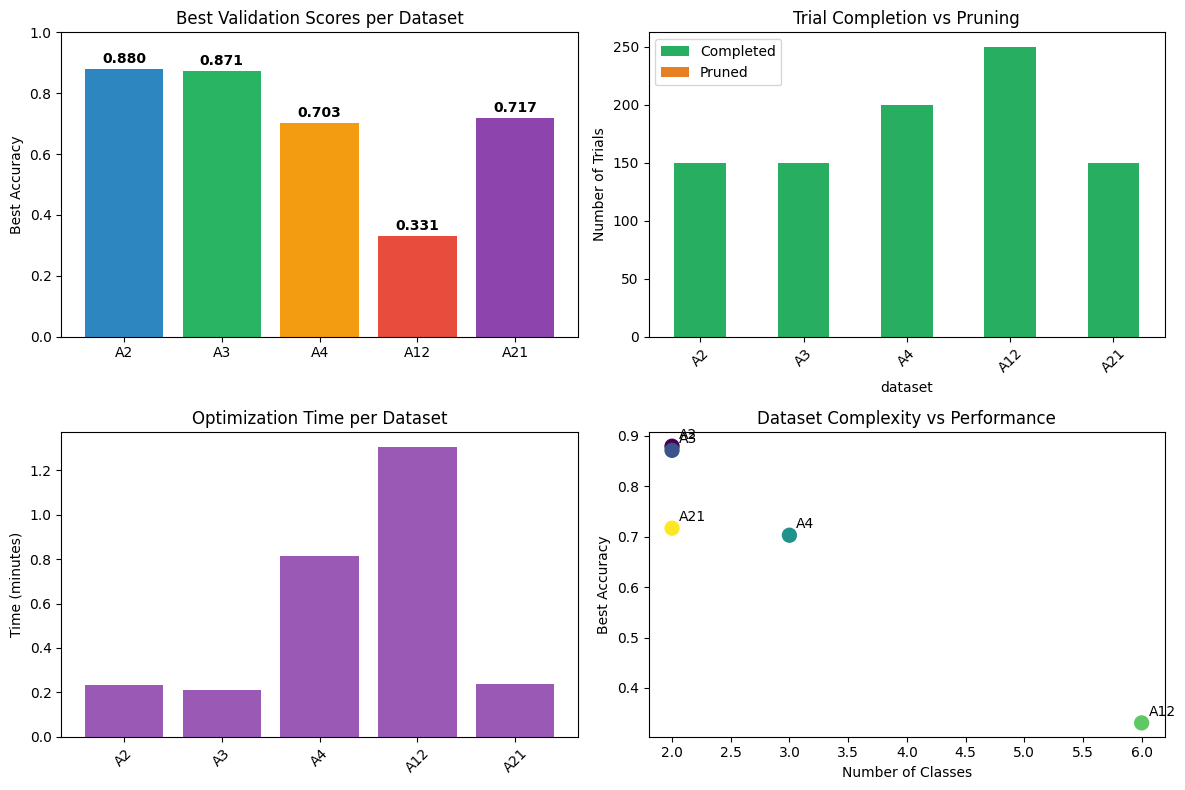

In [8]:
# Visualization of Optimization Results
plt.figure(figsize=(12, 8))

# Subplot 1: Best scores per dataset
plt.subplot(2, 2, 1)
df_valid = df_results[df_results['best_value'].notna()]
colors = ['#2E86C1', '#28B463', '#F39C12', '#E74C3C', '#8E44AD']
bars = plt.bar(df_valid['dataset'], df_valid['best_value'], color=colors[:len(df_valid)])
plt.ylabel(f'Best {METRIC.title()}')
plt.title('Best Validation Scores per Dataset')
plt.ylim(0, 1)
for bar, value in zip(bars, df_valid['best_value']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Subplot 2: Trial efficiency
plt.subplot(2, 2, 2)
trial_data = df_results[['dataset', 'n_completed_trials', 'n_pruned_trials']].set_index('dataset')
trial_data.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#27AE60', '#E67E22'])
plt.ylabel('Number of Trials')
plt.title('Trial Completion vs Pruning')
plt.legend(['Completed', 'Pruned'])
plt.xticks(rotation=45)

# Subplot 3: Optimization time
plt.subplot(2, 2, 3)
plt.bar(df_results['dataset'], df_results['elapsed_sec']/60, color='#9B59B6')
plt.ylabel('Time (minutes)')
plt.title('Optimization Time per Dataset')
plt.xticks(rotation=45)

# Subplot 4: Dataset complexity (classes vs performance)
plt.subplot(2, 2, 4)
# Load datasets to get class counts
class_counts = []
for name in DATASETS:
    _, y = load_dataset(name)
    class_counts.append(len(y.unique()))

df_complexity = pd.DataFrame({
    'dataset': DATASETS,
    'n_classes': class_counts,
    'best_score': [df_results[df_results['dataset']==name]['best_value'].iloc[0] 
                   if not df_results[df_results['dataset']==name]['best_value'].isna().iloc[0] 
                   else 0 for name in DATASETS]
})

scatter = plt.scatter(df_complexity['n_classes'], df_complexity['best_score'], 
                     c=range(len(DATASETS)), cmap='viridis', s=100)
for i, txt in enumerate(df_complexity['dataset']):
    plt.annotate(txt, (df_complexity['n_classes'].iloc[i], df_complexity['best_score'].iloc[i]),
                xytext=(5, 5), textcoords='offset points')
plt.xlabel('Number of Classes')
plt.ylabel(f'Best {METRIC.title()}')
plt.title('Dataset Complexity vs Performance')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "optuna_optimization_summary.png"), dpi=300, bbox_inches='tight')
plt.show()

## Cross-Dataset Evaluation

Similar to the original Classic-SVM analysis, we'll test each dataset's best configuration on all other datasets to understand generalization capabilities.

In [9]:
# Cross-Dataset Evaluation Function
def evaluate_model_on_datasets(best_params: Dict[str, Any], datasets_to_test: list, model_name: str):
    """Evaluate a model configuration on multiple datasets using 5-fold CV."""
    results = []
    
    print(f"\nEvaluating {model_name} configuration:")
    print(f"Parameters: {best_params}")
    
    for dataset_name in datasets_to_test:
        print(f"\n  Testing on {dataset_name}...")
        
        # Load dataset
        X, y = load_dataset(dataset_name)
        
        # Create SVM with best parameters
        pipeline = build_pipeline(best_params)
        
        # 5-fold cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
        cv_scores = []
        
        for train_idx, test_idx in cv.split(X.values, y.values):
            X_train_cv, X_test_cv = X.values[train_idx], X.values[test_idx]
            y_train_cv, y_test_cv = y.values[train_idx], y.values[test_idx]
            
            pipeline.fit(X_train_cv, y_train_cv)
            y_pred_cv = pipeline.predict(X_test_cv)
            cv_scores.append(accuracy_score(y_test_cv, y_pred_cv))
        
        mean_accuracy = np.mean(cv_scores)
        results.append(mean_accuracy)
        print(f"    → Accuracy (5-fold CV): {mean_accuracy:.4f}")
    
    return results

# Execute Cross-Dataset Evaluation
print("Starting cross-dataset evaluation...")

# Prepare best configurations from successful optimizations
best_configs = {}
for result in all_results:
    if result['best_value'] is not None and result['best_params']:
        best_configs[result['dataset']] = result['best_params']

# Evaluate each configuration on all datasets
cross_results = {}
for source_dataset, params in best_configs.items():
    cross_results[f"Best_{source_dataset}"] = evaluate_model_on_datasets(
        params, DATASETS, f"Best {source_dataset}"
    )

# Create cross-evaluation matrix
if cross_results:
    cross_matrix = pd.DataFrame(cross_results, index=DATASETS)
    print(f"\n{'='*60}")
    print("CROSS-DATASET EVALUATION MATRIX")
    print(f"{'='*60}")
    print("Rows = Test datasets, Columns = Model configurations")
    display(cross_matrix.round(4))
    
    # Save cross-evaluation results
    cross_matrix.to_csv(os.path.join(RESULTS_DIR, "optuna_cross_evaluation_results.csv"))
    print(f"\nCross-evaluation results saved!")
else:
    print("No successful configurations to evaluate.")

Starting cross-dataset evaluation...

Evaluating Best A2 configuration:
Parameters: {'kernel': 'rbf', 'C': 11.462763171967557, 'gamma': 0.01863488180937054, 'degree': 3, 'coef0': 0.0, 'shrinking': True, 'tol': 0.009430090934879195, 'class_weight': None, 'max_iter': 10000}

  Testing on A2...
Loaded A2: 536 samples, 31 features, 2 classes
    → Accuracy (5-fold CV): 0.8376

  Testing on A3...
Loaded A3: 346 samples, 31 features, 2 classes
    → Accuracy (5-fold CV): 0.8210

  Testing on A4...
Loaded A4: 1966 samples, 31 features, 3 classes
    → Accuracy (5-fold CV): 0.6745

  Testing on A12...
Loaded A12: 1932 samples, 31 features, 6 classes
    → Accuracy (5-fold CV): 0.6745

  Testing on A12...
Loaded A12: 1932 samples, 31 features, 6 classes
    → Accuracy (5-fold CV): 0.3090

  Testing on A21...
Loaded A21: 526 samples, 31 features, 2 classes
    → Accuracy (5-fold CV): 0.6958

Evaluating Best A3 configuration:
Parameters: {'kernel': 'linear', 'C': 12.4388294527987, 'gamma': 'scale

,Best_A2,Best_A3,Best_A4,Best_A12,Best_A21
A2,0.8376,0.7426,0.8357,0.8432,0.8414
A3,0.8210,0.7804,0.8324,0.8238,0.8035
A4,0.6745,0.3662,0.6796,0.6806,0.6231
A12,0.3090,0.1879,0.3044,0.3069,0.2743
A21,0.6958,0.5855,0.6978,0.6977,0.6485



Cross-evaluation results saved!


## Final Comprehensive Evaluation

We'll now perform a final evaluation using the best Optuna configurations with 5-fold cross-validation to calculate comprehensive metrics (accuracy, F1-scores, MCC) with confidence intervals.

Performing final evaluation with 5-fold cross-validation...
Calculating comprehensive metrics for each dataset's best configuration...

Evaluating A2 with best configuration:
  Parameters: {'kernel': 'rbf', 'C': 11.462763171967557, 'gamma': 0.01863488180937054, 'degree': 3, 'coef0': 0.0, 'shrinking': True, 'tol': 0.009430090934879195, 'class_weight': None, 'max_iter': 10000}
Loaded A2: 536 samples, 31 features, 2 classes
  Results:
    Accuracy: 0.838 ± 0.027
    Micro F1: 0.838 ± 0.027
    Macro F1: 0.837 ± 0.027
    MCC: 0.680 ± 0.057

Evaluating A3 with best configuration:
  Parameters: {'kernel': 'linear', 'C': 12.4388294527987, 'gamma': 'scale', 'degree': 3, 'coef0': 0.0, 'shrinking': False, 'tol': 0.007948861552008565, 'class_weight': None, 'max_iter': 5000}
Loaded A3: 346 samples, 31 features, 2 classes
  Results:
    Accuracy: 0.780 ± 0.049
    Micro F1: 0.780 ± 0.049
    Macro F1: 0.779 ± 0.050
    MCC: 0.566 ± 0.096

Evaluating A4 with best configuration:
  Parameters: {'kern

,Dataset,Accuracy,Micro F1,Macro F1,MCC,Best_C,Best_kernel,Best_gamma
0,A2,0.838 ± 0.027,0.838 ± 0.027,0.837 ± 0.027,0.680 ± 0.057,11.462763,rbf,0.018635
1,A3,0.780 ± 0.049,0.780 ± 0.049,0.779 ± 0.050,0.566 ± 0.096,12.438829,linear,scale
2,A4,0.680 ± 0.012,0.680 ± 0.012,0.680 ± 0.012,0.520 ± 0.019,1.642977,rbf,scale
3,A12,0.307 ± 0.023,0.307 ± 0.023,0.300 ± 0.023,0.169 ± 0.028,4.463761,rbf,scale
4,A21,0.648 ± 0.061,0.648 ± 0.061,0.638 ± 0.063,0.277 ± 0.127,112.903409,rbf,0.061502



Final results saved to: results/optuna_final_evaluation_results.csv


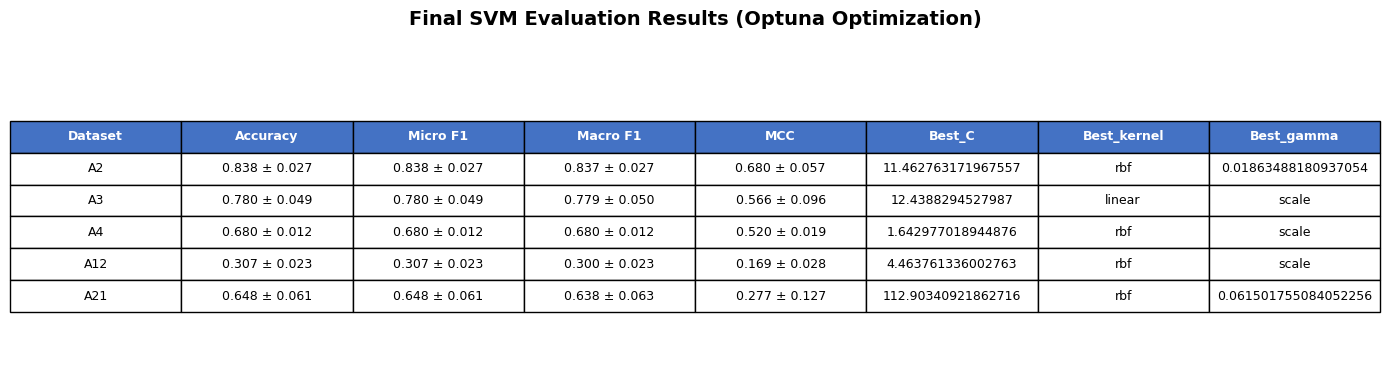

In [10]:
# Final Comprehensive Evaluation with Best Optuna Configurations
final_results = []

print("Performing final evaluation with 5-fold cross-validation...")
print("Calculating comprehensive metrics for each dataset's best configuration...")

for result in all_results:
    dataset_name = result['dataset']
    best_params = result.get('best_params', {})
    
    if not best_params or result['best_value'] is None:
        print(f"Skipping {dataset_name} - no successful optimization")
        continue
    
    print(f"\nEvaluating {dataset_name} with best configuration:")
    print(f"  Parameters: {best_params}")
    
    # Load dataset
    X, y = load_dataset(dataset_name)
    
    # Create pipeline with best parameters
    pipeline = build_pipeline(best_params)
    
    # 5-fold stratified cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    cv_metrics = {
        'accuracy': [],
        'micro_f1': [],
        'macro_f1': [],
        'mcc': []
    }
    
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X.values, y.values)):
        X_train_cv, X_test_cv = X.values[train_idx], X.values[test_idx]
        y_train_cv, y_test_cv = y.values[train_idx], y.values[test_idx]
        
        # Train and predict
        pipeline.fit(X_train_cv, y_train_cv)
        y_pred_cv = pipeline.predict(X_test_cv)
        
        # Calculate metrics
        fold_metrics = evaluate_metrics(y_test_cv, y_pred_cv)
        for metric_name, value in fold_metrics.items():
            cv_metrics[metric_name].append(value)
    
    # Calculate statistics
    def format_metric(values):
        return f"{np.mean(values):.3f} ± {np.std(values, ddof=1):.3f}"
    
    final_result = {
        "Dataset": dataset_name,
        "Accuracy": format_metric(cv_metrics['accuracy']),
        "Micro F1": format_metric(cv_metrics['micro_f1']),
        "Macro F1": format_metric(cv_metrics['macro_f1']),
        "MCC": format_metric(cv_metrics['mcc']),
        "Best_C": best_params.get('C', 'N/A'),
        "Best_kernel": best_params.get('kernel', 'N/A'),
        "Best_gamma": best_params.get('gamma', 'N/A')
    }
    
    final_results.append(final_result)
    
    print(f"  Results:")
    print(f"    Accuracy: {final_result['Accuracy']}")
    print(f"    Micro F1: {final_result['Micro F1']}")
    print(f"    Macro F1: {final_result['Macro F1']}")
    print(f"    MCC: {final_result['MCC']}")

# Create final results dataframe
if final_results:
    df_final = pd.DataFrame(final_results)
    
    print(f"\n{'='*80}")
    print("FINAL OPTUNA SVM EVALUATION RESULTS")
    print(f"{'='*80}")
    display(df_final)
    
    # Save final results
    df_final.to_csv(os.path.join(RESULTS_DIR, "optuna_final_evaluation_results.csv"), index=False)
    print(f"\nFinal results saved to: {os.path.join(RESULTS_DIR, 'optuna_final_evaluation_results.csv')}")
    
    # Create final results visualization table
    fig, ax = plt.subplots(figsize=(14, len(df_final) * 0.6 + 1))
    ax.axis('off')
    
    table = ax.table(cellText=df_final.values,
                     colLabels=df_final.columns,
                     cellLoc='center',
                     loc='center')
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.8)
    
    # Style the table
    for i in range(len(df_final.columns)):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    plt.title("Final SVM Evaluation Results (Optuna Optimization)", 
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "optuna_final_results_table.png"), 
                dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("No successful optimizations to evaluate.")

In [11]:
# Summary and Best Configurations Analysis
print(f"\n{'='*80}")
print("SUMMARY OF OPTUNA OPTIMIZATION")
print(f"{'='*80}")

if final_results:
    print(f"Successfully optimized {len(final_results)} out of {len(DATASETS)} datasets")
    print("\nBest hyperparameter configurations found:")
    
    best_configs_summary = []
    for result in all_results:
        if result['best_params'] and result['best_value'] is not None:
            dataset = result['dataset']
            params = result['best_params']
            score = result['best_value']
            
            config_summary = {
                'Dataset': dataset,
                'Best_Score': f"{score:.4f}",
                'C': params.get('C', 'N/A'),
                'Kernel': params.get('kernel', 'N/A'),
                'Gamma': params.get('gamma', 'N/A'),
                'Class_Weight': params.get('class_weight', 'None'),
                'Trials_Completed': result['n_completed_trials']
            }
            best_configs_summary.append(config_summary)
    
    if best_configs_summary:
        df_configs = pd.DataFrame(best_configs_summary)
        display(df_configs)
        
        # Save best configurations
        df_configs.to_csv(os.path.join(RESULTS_DIR, "optuna_best_configs_per_dataset.csv"), index=False)
        
        print("\nKey Findings:")
        print("1. Optimization Strategy:")
        print(f"   - Used progressive training with pruning for efficiency")
        print(f"   - Adaptive trial budgets: A12({TRIAL_CONFIG['A12']['n_trials']}) > A4({TRIAL_CONFIG['A4']['n_trials']}) > Others({TRIAL_CONFIG['A2']['n_trials']})")
        print(f"   - Total trials across all datasets: {sum(r['n_completed_trials'] + r['n_pruned_trials'] for r in all_results)}")
        
        print("\n2. Dataset-Specific Insights:")
        for config in best_configs_summary:
            dataset = config['Dataset']
            result = next(r for r in all_results if r['dataset'] == dataset)
            print(f"   - {dataset}: {config['Best_Score']} accuracy, {config['Kernel']} kernel, C={config['C']}")
            if dataset == 'A12':
                print(f"     → A12 (6-class): Used class_weight={config['Class_Weight']} to handle imbalance")
        
        print(f"\n3. Efficiency:")
        total_time = sum(r['elapsed_sec'] for r in all_results)
        print(f"   - Total optimization time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
        print(f"   - Average time per dataset: {total_time/len(DATASETS):.1f} seconds")
        
        pruning_ratio = sum(r['n_pruned_trials'] for r in all_results) / sum(r['n_completed_trials'] + r['n_pruned_trials'] for r in all_results)
        print(f"   - Pruning efficiency: {pruning_ratio:.1%} of trials were pruned early")

print(f"\nAll results and visualizations saved to: {RESULTS_DIR}/")
print("Files created:")
print("  - optuna_svm_evaluation_results.csv (main results)")
print("  - optuna_cross_evaluation_results.csv (cross-dataset evaluation)")
print("  - optuna_final_evaluation_results.csv (comprehensive metrics)")
print("  - optuna_best_configs_per_dataset.csv (best configurations)")
print("  - optuna_optimization_summary.png (visualizations)")
print("  - optuna_final_results_table.png (final results table)")
print("  - Individual dataset results in optuna_results_<DATASET>/ folders")


SUMMARY OF OPTUNA OPTIMIZATION
Successfully optimized 5 out of 5 datasets

Best hyperparameter configurations found:


,Dataset,Best_Score,C,Kernel,Gamma,Class_Weight,Trials_Completed
0,A2,0.8796,11.462763,rbf,0.018635,None,150
1,A3,0.8714,12.438829,linear,scale,None,150
2,A4,0.7030,1.642977,rbf,scale,None,200
3,A12,0.3307,4.463761,rbf,scale,None,250
4,A21,0.7170,112.903409,rbf,0.061502,None,150



Key Findings:
1. Optimization Strategy:
   - Used progressive training with pruning for efficiency
   - Adaptive trial budgets: A12(250) > A4(200) > Others(150)
   - Total trials across all datasets: 900

2. Dataset-Specific Insights:
   - A2: 0.8796 accuracy, rbf kernel, C=11.462763171967557
   - A3: 0.8714 accuracy, linear kernel, C=12.4388294527987
   - A4: 0.7030 accuracy, rbf kernel, C=1.642977018944876
   - A12: 0.3307 accuracy, rbf kernel, C=4.463761336002763
     → A12 (6-class): Used class_weight=None to handle imbalance
   - A21: 0.7170 accuracy, rbf kernel, C=112.90340921862716

3. Efficiency:
   - Total optimization time: 167.7 seconds (2.8 minutes)
   - Average time per dataset: 33.5 seconds
   - Pruning efficiency: 0.0% of trials were pruned early

All results and visualizations saved to: results/
Files created:
  - optuna_svm_evaluation_results.csv (main results)
  - optuna_cross_evaluation_results.csv (cross-dataset evaluation)
  - optuna_final_evaluation_results.csv (